In [1]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

In [110]:
# load in 2022 mlb season data

df = pd.read_csv(r'C:\Users\adam.bloebaum\.vscode\driveline\2022_MLB_Season.csv')

# load in 2023 mlb season data

df_2023 = pd.read_csv(r"C:\Users\adam.bloebaum\.vscode\driveline\2023_MLB_Season.csv")

In [111]:
# load in linear weights for events

linear_weights = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\linear_weights.csv")

In [112]:
# load in calculated expected metrics

xpfx_x = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022&3_pfx_x_predictions.csv")
xpfx_z = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022&3_pfx_z_predictions.csv")
xspin_axis = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022&3_spin_axis_predictions.csv")
xswing = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022&3_swing_predictions.csv")
xwhiff = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022&3_whiff_predictions.csv")

xfb = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\fb_2022&3_xfb.csv")
xgrb = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\gb_2022&3_xgb.csv")
xld = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\ld_2022&3_xld.csv")

In [113]:
# rename and drop columns from expected dfs

xpfx_z.rename(columns={'pfx_z': 'pfx_z_cor'}, inplace=True)
xpfx_z.rename(columns={'pfx_z_predicted': 'pfx_z_cor_predicted'}, inplace=True)
xpfx_z.rename(columns={'pfx_z_diff': 'pfx_z_cor_diff'}, inplace=True)
xpfx_z.rename(columns={'pfx_z_diff_abs': 'pfx_z_cor_diff_abs'}, inplace=True)

xspin_axis.rename(columns={'spin_axis': 'spin_axis_cor'}, inplace=True)

xswing = xswing[['pitch_id_raw', 'swing_predicted']]
xwhiff = xwhiff[['pitch_id_raw', 'whiff_predicted']]

xfb = xfb[['pitch_id_raw', 'xfb']]
xgrb = xgrb[['pitch_id_raw', 'xgb']]
xld = xld[['pitch_id_raw', 'xld']]

In [114]:
# ensure df is sequential

df.sort_values(by=['game_pk', 'inning', 'at_bat_number', 'pitch_number'], inplace=True)

# convert batter handedness columns to binary

stand_encoder = LabelEncoder()
all_stand = pd.concat([df['stand'], df_2023['stand']]).unique()
stand_encoder.fit(all_stand)

df['stand'] = stand_encoder.transform(df['stand'])

# generate unique id column

df['pitch_id_raw'] = df['game_pk'].astype(str) + "_" + \
                            df['batter'].astype(str) + "_" + \
                            df['pitcher'].astype(str) + "_" + \
                            df['pitch_number'].astype(str) + "_" + \
                            df['at_bat_number'].astype(str) + "_" + \
                            df['inning'].astype(str)

# select only fastballs

df = df[df['pitch_type'].isin(['FF', 'SI', 'FC', 'FA', 'FT'])]

# normalize LHP values to RHP standards

df.loc[df['p_throws'] == 'L', 'pfx_x'] = df['pfx_x'] * -1
df.loc[df['p_throws'] == 'L', 'release_pos_x'] = df['release_pos_x'] * -1
df['spin_axis'] = 360 - df['spin_axis']

# total movement column

df['pfx_total'] = abs(df['pfx_x']) + abs(df['pfx_z'])

# movement ratio column

df['pfx_x_ratio'] = abs(df['pfx_x']) / df['pfx_total']
df['pfx_z_ratio'] = abs(df['pfx_z']) / df['pfx_total']

In [115]:
# ensure df is sequential

df_2023.sort_values(by=['game_pk', 'inning', 'at_bat_number', 'pitch_number'], inplace=True)

# convert batter handedness columns to binary

df_2023['stand'] = stand_encoder.transform(df_2023['stand'])

# generate unique id column

df_2023['pitch_id_raw'] = df_2023['game_pk'].astype(str) + "_" + \
                            df_2023['batter'].astype(str) + "_" + \
                            df_2023['pitcher'].astype(str) + "_" + \
                            df_2023['pitch_number'].astype(str) + "_" + \
                            df_2023['at_bat_number'].astype(str) + "_" + \
                            df_2023['inning'].astype(str)

# select only fastballs

df_2023 = df_2023[df_2023['pitch_type'].isin(['FF', 'SI', 'FC', 'FA', 'FT'])]

# normalize LHP values to RHP standards

df_2023.loc[df_2023['p_throws'] == 'L', 'pfx_x'] = df_2023['pfx_x'] * -1
df_2023.loc[df_2023['p_throws'] == 'L', 'release_pos_x'] = df_2023['release_pos_x'] * -1
df_2023['spin_axis'] = 360 - df['spin_axis']

# total movement column

df_2023['pfx_total'] = abs(df_2023['pfx_x']) + abs(df_2023['pfx_z'])

# movement ratio column

df_2023['pfx_x_ratio'] = abs(df_2023['pfx_x']) / df_2023['pfx_total']
df_2023['pfx_z_ratio'] = abs(df_2023['pfx_z']) / df_2023['pfx_total']

In [116]:
# create outcome column using events and description columns

events_mapping = {
    'field_out': 'field_out',
    'force_out': 'field_out',
    'fields_choice_out': 'field_out',
    'fielders_choice': 'field_out',
    'other_out': 'field_out',
    'sac_fly': 'field_out',
    'sac_bunt': 'field_out',
    'walk': 'walk',
    'hit_by_pitch': 'walk',
    'strikeout': 'strikeout',
    'grounded_into_double_play': 'double_play',
    'double_play': 'double_play',
    'strikeout_double_play': 'double_play',
    'sac_fly_double_play': 'double_play',
    'single': 'single',
    'double': 'double',
    'triple': 'triple',
    'home_run': 'home_run'    
}


description_mapping = {
    'ball': 'ball',
    'called_strike': 'strike',
    'foul': 'foul',
    #'hit_into_play': 'hit_into_play',
    'swinging_strike': 'strike',
    'foul_tip': 'foul',
    'hit_by_pitch': 'walk',
    'blocked_ball': 'ball' ,
    'missed_bunt': 'strike',
    'foul_bunt': 'foul',
    'swinging_strike_blocked': 'strike',
    'bunt_foul_tip': 'foul'
}

In [117]:
# function for using mappings to determine outcome

def determine_outcome(row):
    
    event = row['events']
    description = row['description']
    
    if event in events_mapping:
        return events_mapping[event]

    elif description in description_mapping:
        return description_mapping[description]

    else:
        return np.nan

# apply function to each row

df['outcome'] = df.apply(determine_outcome, axis=1)
df_2023['outcome'] = df_2023.apply(determine_outcome, axis=1)

In [118]:
# drop na outcome rows

df.dropna(subset=['outcome'], inplace=True)
df_2023.dropna(subset=['outcome'], inplace=True)

In [119]:
# create outcome label encoder

outcome_encoder = LabelEncoder()

# get all possible outcome values

all_outcome = pd.concat([df['outcome'], df_2023['outcome']]).unique()
outcome_encoder.fit(all_outcome)

# label encode the outcome column

df['outcome'] = outcome_encoder.transform(df['outcome'])
df_2023['outcome'] = outcome_encoder.transform(df_2023['outcome'])

In [120]:
# perform left joins

df = pd.merge(df, xpfx_x, on='pitch_id_raw', how='left')
df = pd.merge(df, xpfx_z, on='pitch_id_raw', how='left')
df = pd.merge(df, xspin_axis, on='pitch_id_raw', how='left')
df = pd.merge(df, xswing, on='pitch_id_raw', how='left')
df = pd.merge(df, xwhiff, on='pitch_id_raw', how='left')

df = pd.merge(df, xfb, on='pitch_id_raw', how='left')
df = pd.merge(df, xgrb, on='pitch_id_raw', how='left')
df = pd.merge(df, xld, on='pitch_id_raw', how='left')


# perform left joins

df_2023 = pd.merge(df_2023, xpfx_x, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xpfx_z, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xspin_axis, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xswing, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xwhiff, on='pitch_id_raw', how='left')

df_2023 = pd.merge(df_2023, xfb, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xgrb, on='pitch_id_raw', how='left')
df_2023 = pd.merge(df_2023, xld, on='pitch_id_raw', how='left')

In [121]:
# convert all negative swing probabilities to zero (bug)

df.loc[df['swing_predicted'] < 0, 'swing_predicted'] = 0
df_2023.loc[df_2023['swing_predicted'] < 0, 'swing_predicted'] = 0

In [122]:
# create combination term of swing and whiff probabilities

df['swing_whiff'] = df['swing_predicted'] * df['whiff_predicted']
df_2023['swing_whiff'] = df_2023['swing_predicted'] * df_2023['whiff_predicted']

In [124]:
# feature selection and data splitting

features = ['release_speed', 'release_pos_x', 'release_pos_y', 'release_pos_z', 'release_extension', 'release_spin_rate', 'pfx_total', 'pfx_x_ratio', 'pfx_z_ratio', 'pfx_x_cor', \
            'pfx_x_cor_predicted', 'pfx_x_cor_diff', 'pfx_x_cor_diff_abs', 'pfx_z_cor', 'pfx_z_cor_predicted', 'pfx_z_cor_diff_abs', 'spin_axis_cor', 'spin_axis_predicted', \
                'spin_axis_diff', 'spin_axis_diff_abs', 'arm_slot', 'height_ratio', 'swing_predicted', 'whiff_predicted', 'swing_whiff', 'xfb', 'xgb', 'xld']

# copy and keep only features

df_2023_features = df_2023[features]

# create features and targets

X = df[features]
y = df['outcome']

# train valid test split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [125]:
# set up model

model = xgb.XGBClassifier(objective='multi:softmax', num_class=11, eval_metric='mlogloss', use_label_encoder=False)

# train model

model.fit(X_train, y_train)

c:\Users\adam.bloebaum\AppData\Local\miniconda3\envs\driveline\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_class=11, num_parallel_tree=None, objective='multi:softmax', ...)

In [126]:
# make predictions

y_pred = model.predict(X_valid)

# evaluate the model

accuracy = accuracy_score(y_valid, y_pred)
conf_matrix = confusion_matrix(y_valid, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.4205818465818954
Confusion Matrix:
[[18947     0     0    47  3126     0     1  3081    15     0     3]
 [  191     0     0     2   474     0     0   325     0     0     0]
 [  102     0     0     4   198     0     0   153     1     0     0]
 [ 1841     0     0    64  4342     0     0  3123     6     0     2]
 [ 3730     0     0    91  8398     0     1  5156    20     0     1]
 [   90     0     0     1   326     0     0   234     0     0     0]
 [  652     0     0    20  1528     0     0  1087     1     0     1]
 [ 4599     0     0    94  6583     0     0  7040    12     0     0]
 [ 1383     0     0    19  1618     0     0   869    15     0     2]
 [   12     0     0     0    36     0     0    22     0     0     0]
 [ 1716     0     0     4   234     0     0   302     0     0     1]]


<Figure size 1000x5000 with 0 Axes>

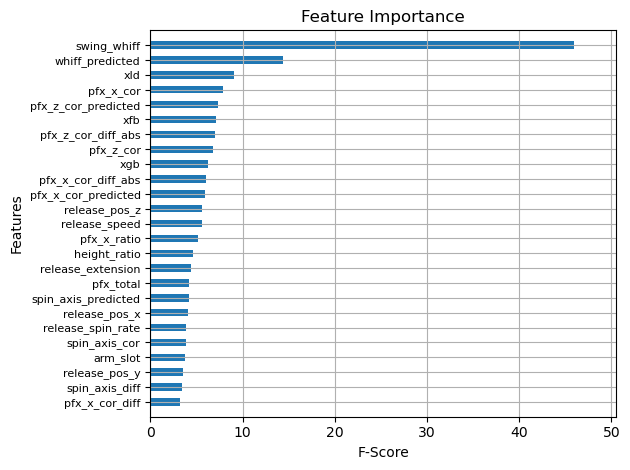

In [127]:
plt.figure(figsize=(10, 50))  # You may adjust this if needed
xgb.plot_importance(model, importance_type='gain', show_values=False, height=0.5)
plt.title('Feature Importance')
plt.xlabel('F-Score')
plt.ylabel('Features')
plt.yticks(fontsize=8)  # You can adjust fontsize if the labels are too crowded
plt.tight_layout()  # Adjust the layout to fit all labels and titles
plt.savefig('feature_importance_fb.png', dpi=300)  # Save with high resolution
plt.show()

In [128]:
# get feature importance dictionary

importance = model.get_booster().get_score(importance_type='gain')

# sort features by importance

sorted_importance = sorted(importance.items(), key=lambda item: item[1], reverse=True)

# loop to print

for feature, score in sorted_importance:
    print(f'{feature}: {score}')

swing_whiff: 45.91322708129883
whiff_predicted: 14.40030574798584
xld: 9.065889358520508
pfx_x_cor: 7.8626179695129395
pfx_z_cor_predicted: 7.296238422393799
xfb: 7.078188419342041
pfx_z_cor_diff_abs: 6.967550277709961
pfx_z_cor: 6.790237903594971
xgb: 6.311100959777832
pfx_x_cor_diff_abs: 6.081559658050537
pfx_x_cor_predicted: 5.899377346038818
release_pos_z: 5.618085861206055
release_speed: 5.5876898765563965
pfx_x_ratio: 5.170269012451172
height_ratio: 4.663109302520752
release_extension: 4.44110631942749
pfx_total: 4.176395893096924
spin_axis_predicted: 4.159878730773926
release_pos_x: 4.121554851531982
release_spin_rate: 3.9064412117004395
spin_axis_cor: 3.8440935611724854
arm_slot: 3.7562084197998047
release_pos_y: 3.535229206085205
spin_axis_diff: 3.418513059616089
pfx_x_cor_diff: 3.2384486198425293


In [129]:
# generate outcome probabilities on 2023 mlb season data

outcome_probabilities = model.predict_proba(df_2023_features)

# apply outcome probabilities back onto full df

for i, class_label in enumerate(model.classes_):
    df_2023[f'prob_{class_label}'] = outcome_probabilities[:, i]

In [130]:
# label encode linear weights to match outcome

linear_weights = linear_weights[linear_weights['description'] != 'caught_stealing_2b']
linear_weights['outcome'] = outcome_encoder.transform(linear_weights['description'])

In [131]:
linear_weight_values = linear_weights.set_index('outcome')['linear_weight']

# weighted sum of each outcome's probability * each outcome's linear weight run value

df_2023['pitch_quality'] = sum(
    df_2023[f'prob_{i}'] * linear_weight_values[i] for i in range(11)
)

In [132]:
# group by player name and pitch type for pitches a player threw more than 100 times

grouped_data = df_2023.groupby(['player_name', 'pitch_type']).filter(lambda x: len(x) > 100)

# group by player name and pitch type and get the mean pitch quality

pitch_quality_sum = grouped_data.groupby(['player_name', 'pitch_type'])['pitch_quality'].mean().reset_index()

# sort the results by pitch quality in descending order and take the top 10

top_10 = pitch_quality_sum.sort_values(by='pitch_quality', ascending=False).head(10)

# sort the results by pitch quality in ascending order and take the bottom 10

bottom_10 = pitch_quality_sum.sort_values(by='pitch_quality', ascending=True).head(10)

# print results

print("Top 10:")
print(top_10)
print("\nBottom 10:")
print(bottom_10)

Top 10:
            player_name pitch_type  pitch_quality
581           Moll, Sam         FF       0.023247
355     Hendricks, Kyle         FF       0.020585
424     Kauffmann, Karl         FF       0.019461
44         Bard, Daniel         FF       0.018925
115  Bumgarner, Madison         FF       0.018011
219        Doyle, Tommy         FF       0.017314
870    Wainwright, Adam         SI       0.017287
619      Ohtani, Shohei         SI       0.016233
869    Wainwright, Adam         FF       0.016224
421   Kaprielian, James         FF       0.015735

Bottom 10:
          player_name pitch_type  pitch_quality
159   Clase, Emmanuel         FC      -0.025979
145  Chapman, Aroldis         SI      -0.022654
354     Helsley, Ryan         FF      -0.021770
546       May, Dustin         SI      -0.018685
150      Cimber, Adam         FF      -0.018476
686   Rasmussen, Drew         FC      -0.018347
792  Strider, Spencer         FF      -0.018033
855       Vesia, Alex         FF      -0.01712

In [133]:
# determine max and min avg pitch quality values

max_val = pitch_quality_sum['pitch_quality'].max()
min_val = pitch_quality_sum['pitch_quality'].min()

# create normalized stuff+ metric centered around 100

pitch_quality_sum['stuff_plus'] = max_val - pitch_quality_sum['pitch_quality']
mean_stuff = pitch_quality_sum['stuff_plus'].mean()
scaling_factor = 100 / mean_stuff
pitch_quality_sum['stuff_plus'] = pitch_quality_sum['stuff_plus'] * scaling_factor
pitch_quality_sum['stuff_plus'] += 100 - pitch_quality_sum['stuff_plus'].mean()

# sort by stuff plus in ascending order

sorted_pitch_quality_sum = pitch_quality_sum.sort_values(by='stuff_plus', ascending=False)

# reset index and +1 to get rank column

sorted_pitch_quality_sum = sorted_pitch_quality_sum.reset_index()
sorted_pitch_quality_sum.index = sorted_pitch_quality_sum.index + 1

# convert to int for rounding

sorted_pitch_quality_sum['stuff_plus'] = sorted_pitch_quality_sum['stuff_plus'].astype(int)

# print name, pitch type, and stuff plus top 50

sorted_pitch_quality_sum[['player_name', 'pitch_type', 'stuff_plus']].head(50)

,player_name,pitch_type,stuff_plus
1,"Clase, Emmanuel",FC,213
2,"Chapman, Aroldis",SI,198
3,"Helsley, Ryan",FF,194
4,"May, Dustin",SI,181
5,"Cimber, Adam",FF,180
6,"Rasmussen, Drew",FC,179
7,"Strider, Spencer",FF,178
8,"Vesia, Alex",FF,174
9,"Gray, Sonny",FC,174
10,"Megill, Trevor",FF,172


In [134]:
# select top 25 rows

top_25_rows = sorted_pitch_quality_sum[['player_name', 'pitch_type', 'stuff_plus']].head(25)

# plotting rankings as a table

fig, ax = plt.subplots(figsize=(5, 6))
ax.axis('tight')
ax.axis('off')
ax.set_title('Top 25 Fastball Stuff+')
table = ax.table(cellText=top_25_rows.values,
                 colLabels=top_25_rows.columns,
                 loc='center',
                 cellLoc='center',
                 colLoc='center',
                 colWidths=[0.4, 0.2, 0.2])
plt.tight_layout()

# save fig and close

plt.savefig(r'C:\Users\adam.bloebaum\.vscode\driveline\stuff_plus_fb_v4.png', dpi=300)
plt.close()


In [ ]:
# save 2022 and 2023 dfs to y drive

df.to_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022_MLB_xfeatures_stuff_plus.csv")
df.to_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2023_MLB_xfeatures_stuff_plus.csv")

In [279]:
for col in df.columns:
    print(col)

Unnamed: 0
pitch_type
game_date
release_speed
release_pos_x
release_pos_z
player_name
batter
pitcher
events
description
spin_dir
spin_rate_deprecated
break_angle_deprecated
break_length_deprecated
zone
des
game_type
stand
p_throws
home_team
away_team
type
hit_location
bb_type
balls
strikes
game_year
pfx_x
pfx_z
plate_x
plate_z
on_3b
on_2b
on_1b
outs_when_up
inning
inning_topbot
hc_x
hc_y
tfs_deprecated
tfs_zulu_deprecated
fielder_2
umpire
sv_id
vx0
vy0
vz0
ax
ay
az
sz_top
sz_bot
hit_distance_sc
launch_speed
launch_angle
effective_speed
release_spin_rate
release_extension
game_pk
pitcher.1
fielder_2.1
fielder_3
fielder_4
fielder_5
fielder_6
fielder_7
fielder_8
fielder_9
release_pos_y
estimated_ba_using_speedangle
estimated_woba_using_speedangle
woba_value
woba_denom
babip_value
iso_value
launch_speed_angle
at_bat_number
pitch_number
pitch_name
home_score
away_score
bat_score
fld_score
post_away_score
post_home_score
post_bat_score
post_fld_score
if_fielding_alignment
of_fielding_alignme

In [286]:
def heater_stats(df):
    grouped_df = df.groupby(['player_name', 'pitch_type'])[['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'ax', 'ay', 'az', 'vx0', 'vy0', 'vz0', 'release_spin_rate', 'release_extension', 'spin_axis']].mean().reset_index()
    idx = grouped_df.groupby(['player_name'])['release_speed'].transform(max) == grouped_df['release_speed']
    heater_df = grouped_df[idx]
    heater_df = heater_df.groupby('player_name').head(1).reset_index(drop=True)
    final_df = heater_df.rename(columns={col: f'fb_{col}' if col != 'player_name' else col for col in heater_df.columns})
    return final_df

heaters_2022 = heater_stats(df)

heaters_2022.head(5)

,player_name,fb_pitch_type,fb_release_speed,fb_release_pos_x,fb_release_pos_z,fb_pfx_x,fb_pfx_z,fb_ax,fb_ay,fb_az,fb_vx0,fb_vy0,fb_vz0,fb_release_spin_rate,fb_release_extension,fb_spin_axis
0,"Abbott, Cory",FF,91.339394,-2.604336,5.483357,-0.958858,1.433054,-13.081828,29.542563,-14.719764,8.050058,-132.711096,-3.466317,2252.992974,6.273660,140.946136
1,"Abreu, Albert",SI,98.542120,-1.716819,5.690630,-1.225072,1.095673,-18.387419,33.002983,-15.709709,6.615544,-143.233904,-6.668397,2200.747851,6.616905,140.134670
2,"Abreu, Bryan",FF,97.265184,-1.868743,5.770135,-0.531605,1.431257,-8.659995,33.613207,-11.755046,6.546375,-141.353165,-6.171281,2318.727273,6.508704,149.615087
3,"Acevedo, Domingo",FF,93.019529,-1.872165,5.399200,-1.135859,1.113153,-15.536291,30.177170,-17.953813,7.259131,-135.221947,-3.487165,2117.807059,5.730824,127.442353
4,"Adam, Jason",FF,94.768831,-1.647597,5.844773,-0.568442,1.468604,-8.478304,31.858367,-12.589142,5.438304,-137.829760,-4.791478,2656.357143,6.700325,145.918831
